# Document Similarity
### Using FastText Word Embedding
https://fasttext.cc/docs/en/aligned-vectors.html

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
rand_seed = 4

In [3]:
from gensim.models import KeyedVectors
import numpy as np

Importing pre-trained FastText word embeddings of English words. We chose to use aligned word vectors, which will enable us to provide cross-lingual support.

In [4]:
wiki_en_align = '../data/fasttext/wiki.en.align.vec'
# get fasttext wiki embeddings for english
wv_wiki_en = KeyedVectors.load_word2vec_format(wiki_en_align)
print('english words {}'.format(len(list(wv_wiki_en.vocab.keys()))))

english words 2519370


Importing documents from EUR-Lex database.

In [5]:
# import postgresql
#from modules.library.postgresql import PostgresQL
import psycopg2
# connect to the postgresql database
conn = psycopg2.connect(user='postgres', password='dbpass', database='eurlex_environment_only')
pg = conn.cursor()
print(conn.get_dsn_parameters())

{'user': 'postgres', 'dbname': 'eurlex_environment_only', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [6]:
documents = pg.execute("""
    SELECT * FROM documents WHERE document_celex_num='22015P0513(01)';
""")

In [7]:
documents = pg.fetchall()
documents[0]

(2484,
 '22015P0513(01)',
 'Joint Parliamentary Assembly of the Partnership Agreement concluded between the Members of the African, Caribbean and Pacific Group of States, of the one part, and the European Union and its Member States, of the other part — Minutes of the sitting of Monday, 1 December 2014',
 'ACP–EU Joint Parliamentary Assembly',
 'Notice',
 datetime.date(2014, 12, 1),
 '13.5.2015\xa0\xa0\xa0ENOfficial Journal of the European UnionC 160/1JOINT PARLIAMENTARY ASSEMBLY OF THE PARTNERSHIP AGREEMENT CONCLUDED BETWEEN THE MEMBERS OF THE AFRICAN, CARIBBEAN AND PACIFIC GROUP OF STATES, OF THE ONE PART, AND THE EUROPEAN UNION AND ITS MEMBER STATES, OF THE OTHER PARTMINUTES OF THE SITTING OF MONDAY, 1\xa0December 2014(2015/C 160/01)ContentsFormal inaugural sitting1Sitting of the Joint Parliamentary Assembly2Composition of the Joint Parliamentary Assembly2Accreditation of non-parliamentary representatives21.Adoption of agenda (AP101.704)22.Approval of the minutes of the final sittin

## Processing Data

Preparing list of stopwords (words that appear regularly in the vocabulary and are not so significant for a specific document).

In [8]:
# import natural language toolkit
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation
from nltk.corpus   import stopwords
# import nltk
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize

import string
# prepare stopword list
stop_words = stopwords.words('english') + list(string.punctuation)

Tokenize the text of the document - remove stopwords and punctuation and split it in words. We also count the occurance of words in the document and order them by number of occurances decreasingly.

In [9]:
import operator
def tokenize(text, stopwords):
    """Tokenizes and removes stopwords from the document"""
    
    def strip_comments(s):
        s = s.replace('"', '')
        s = s.replace("'", '')
        s = s.replace('“', '')
        s = s.replace('”', '')
        return s
    
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation]
    
    stripped_text = strip_comments(text)
    tokens = preprocess_string(stripped_text, CUSTOM_FILTERS)
    filtered = [w for w in tokens if not w in stopwords]
    
    return filtered
    # get the most frequent words in the document
    count = { }
    for word in filtered:
        if word not in count:
            count[word] = 0
        count[word] += 1
    
    word_sorted = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
    return word_sorted

In [10]:
document_tokens = tokenize(documents[0][-1], stop_words)
print(document_tokens)

['13', '5', '2015', 'enofficial', 'journal', 'european', 'unionc', '160', '1joint', 'parliamentary', 'assembly', 'partnership', 'agreement', 'concluded', 'members', 'african', 'caribbean', 'pacific', 'group', 'states', 'one', 'part', 'european', 'union', 'member', 'states', 'partminutes', 'sitting', 'monday', '1', 'december', '2014', '2015', 'c', '160', '01', 'contentsformal', 'inaugural', 'sitting1sitting', 'joint', 'parliamentary', 'assembly2composition', 'joint', 'parliamentary', 'assembly2accreditation', 'non', 'parliamentary', 'representatives21', 'adoption', 'agenda', 'ap101', '704', '22', 'approval', 'minutes', 'final', 'sitting', '27th', 'session', 'joint', 'parliamentary', 'assembly', 'oj', 'c', '345', '2', '10', '2014', '23', 'co', 'presidents’', 'announcements', 'including', 'decisions', 'taken', 'bureau', 'meeting', '30', 'november', '201424', 'statement', 'mohamed', 'diaré', 'minister', 'state', 'economic', 'affairs', 'finance', 'republic', 'guinea', 'president', 'office',

In [11]:
'deforestation' in document_tokens

True

In [12]:
'deforestation' in wv_wiki_en.vocab.keys()

True

Sort through tokens of the document and keep the ones that appear in FastText word embeddings. Furthermore, keep their word vectors in 'vectors' variable.

In [13]:
words = []
vectors = []
for token in set(document_tokens):
    if token in wv_wiki_en.vocab.keys():
        words.append(token)
        vectors.append(wv_wiki_en[token])  # numpy vector of a word

In [14]:
print('tokens: {}, words, {}, vectors: {}'.format(len(document_tokens), len(words), len(vectors)))

tokens: 1105, words, 545, vectors: 545


Prepare word vectors (that have high dimension) for embedding in a lower dimensional space in order to be plotted.

In [15]:
#import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=rand_seed).fit_transform(vectors)
X_embedded.shape

(545, 2)

(-37.0012131690979, 34.67729387283325, -41.13752708435059, 46.98213920593261)

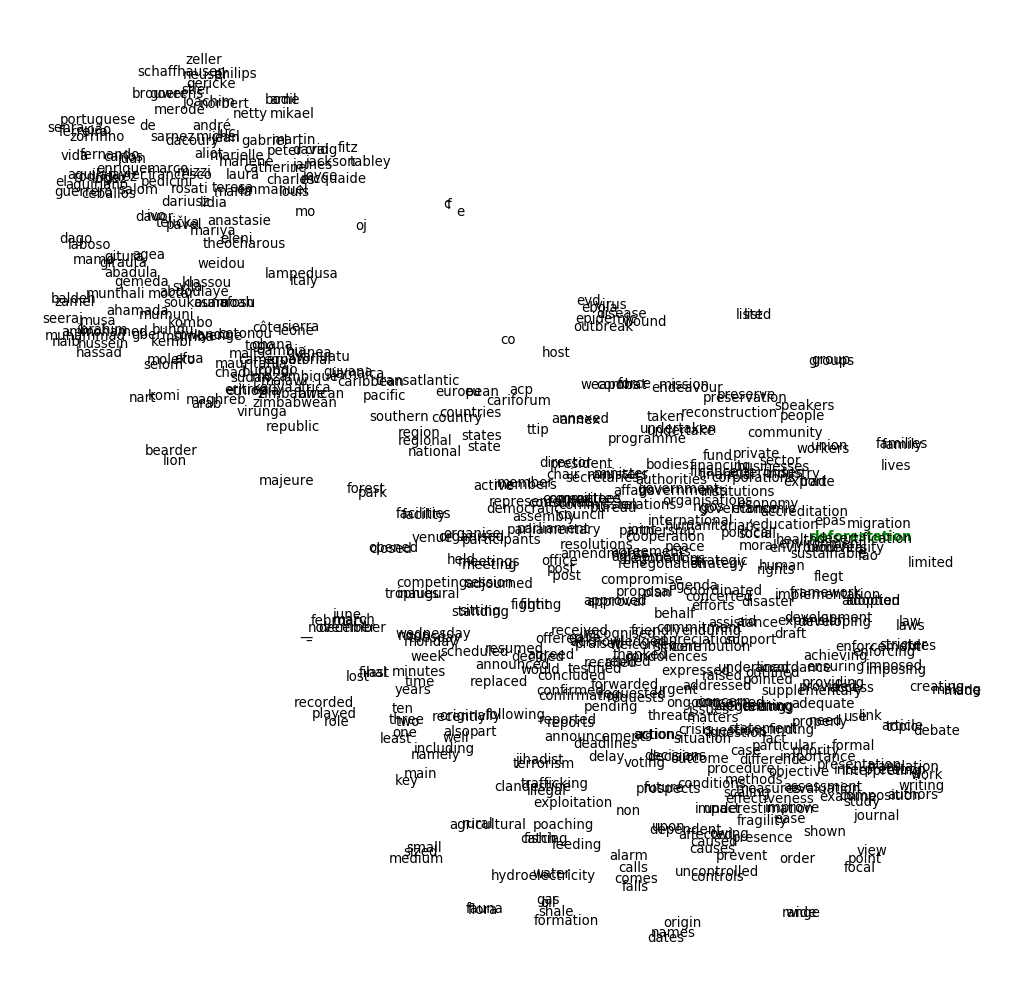

In [16]:
# import matplotlib
import matplotlib.pyplot as plt
# unit area ellipse
x, y = X_embedded.transpose()[0], X_embedded.transpose()[1]

%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), dpi=160, facecolor='w')
ax.scatter(x, y, 0)

n = words
for i, txt in enumerate(n):
    weight = 'normal'
    color = 'black'
    if txt == 'deforestation':
        weight = 'bold'
        color = 'green'
    ax.annotate(txt, (x[i], y[i]), color=color, weight=weight, ha='center', va='center', size=6)
plt.axis('off')

Find the embedding for word 'deforestation'. Compute k most similar words, where similarity is measured with euclid distance of word vectors, and plot 'deforestation' and found word vectors.

In [17]:
embedding = X_embedded[words.index('deforestation')]

In [18]:
def euclid_similarity(emb1, emb2):
    """Calculate the euclid similarity between two embeddings"""
    return np.linalg.norm(emb1 - emb2)

In [19]:
def k_nearest_neighbors(embedding, k, we=X_embedded, words=words, similarity=euclid_similarity):
    """Get the k nearest neighbors of a particular material"""
    # calculate the similarities and revert it
    sims = [similarity(embedding, w) for w in we]
    # sort and get the corresponding values and weights
    distances = []
    neighbors = []
    for c, index in enumerate(np.argsort(sims)):
        # break if we had enough values
        if c == k:
            break
        distances.append(sims[index])
        neighbors.append(words[index])
    # return the documents and weights
    return neighbors, distances

In [20]:
neighbors, distances = k_nearest_neighbors(embedding, k=20)
print(neighbors)
print(distances)

['deforestation', 'desertification', 'biodiversity', 'fao', 'migration', 'epas', 'sustainable', 'environment', 'environmental', 'flegt', 'health', 'accreditation', 'limited', '‘education', 'framework', 'implementation', 'adoption', 'trade', 'adopted', 'human']
[0.0, 0.2599394, 1.5072807, 1.7702063, 1.8077915, 2.6678307, 2.7532082, 2.9500246, 3.2504728, 4.3036327, 4.6070704, 4.7273946, 5.5612288, 5.6646757, 5.699555, 5.742233, 5.8760076, 5.8998523, 5.9044595, 6.2749686]


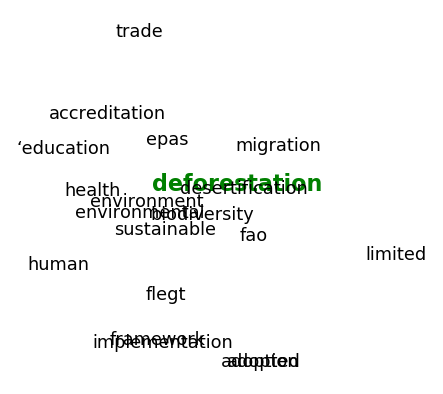

In [21]:
# import matplotlib
import matplotlib.pyplot as plt
# unit area ellipse
x, y = X_embedded.transpose()[0], X_embedded.transpose()[1]

fig, ax = plt.subplots(figsize=(3, 3), dpi=160, facecolor='w')

n = words
for i, txt in enumerate(n):
    if txt in neighbors:
        weight = 'normal'
        color = 'black'
        size = 8
        if txt == 'deforestation':
            weight = 'bold'
            color = 'green'
            size = 10
        ax.scatter(x[i], y[i], 0)
        ax.annotate(txt, (x[i], y[i]), color=color, weight=weight, ha='center', va='center', size=size)
plt.axis('off')
plt.show()

## Document embeddings

In this section we write several document embeddings. They will be used later to find the optimal way to represent our data.

Save all documents of EUR-Lex database into a variable 'documents'.

In [23]:
documents = pg.execute("""
    SELECT * FROM documents;
""")
documents = pg.fetchall()

In [24]:
N = len(documents)
print(N)

123157


### Document embedding via word embeddings

We will first implement a simple version of document embedding that relies on the fact, that we already have a basis of word embeddings. Document embedding will be defined as an average of word embeddings of words that appear in 'document_text'.

In [25]:
def document_embedding_average(text, stopwords, wv):
    """Creates a document embedding by aggregating the corresponding token embeddings"""
    embedding = np.zeros(wv.vector_size, dtype=np.float32)
    
    if text is None:
        return embedding
    
    word_sorted = tokenize(text, stopwords)
    norm = 0
    for token in word_sorted:
        # sum all tokens embeddings of the vector
        if token in wv.vocab.keys():
            embedding += wv[token] 
            norm += 1
    # return the normalized embedding; if not zero
    return embedding if norm == 0 else embedding / norm

We embed documents in our database. As shown before the total number of documents in the database is more than 100.000, so we limit ourselves and embed only 15.000.

In [28]:
def dataset_embedding(dataset, stopwords, wv, document_embedding):
    """Creates the dataset embeddings given a document_embedding function"""
    embeddings = np.zeros((len(dataset), wv.vector_size), dtype=np.float32)
    for id, document in enumerate(dataset):
        # text = document['document_text']
        text = document[-1]
        embeddings[id,:] = document_embedding(text, stopwords, wv)
        if id % 1000 == 0:
            print('Processed document number = {}'.format(id))
    return embeddings

In [29]:
limit = 15000
we = dataset_embedding(documents[:limit], stop_words, wv_wiki_en, document_embedding_average)

Processed document number = 0
Processed document number = 1000
Processed document number = 2000
Processed document number = 3000
Processed document number = 4000
Processed document number = 5000
Processed document number = 6000
Processed document number = 7000
Processed document number = 8000
Processed document number = 9000
Processed document number = 10000
Processed document number = 11000
Processed document number = 12000
Processed document number = 13000
Processed document number = 14000


We filter through them and pick only the ones with non-zero embeddings (the ones with 'document_text' differet then 'None').

In [30]:
# TODO: Documents without text have document_text parameter and its value is set to:
# Full text of documents was either not avaiable or we were not able to collect it.
# SOLVED
non_null = [x for x in we if np.linalg.norm(x) != 0]
non_null_id = [i for i in range(len(we)) if np.linalg.norm(we[i]) != 0]
len(non_null)

15000

In order to plot the embeddings we need to reduce the dimension to 2 (or 3). We use the TSNE method and plot the embeddings.

In [31]:
docembeddings_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(non_null)

In [32]:
XX = docembeddings_transformed[:4000, :]
XX.shape

(4000, 2)

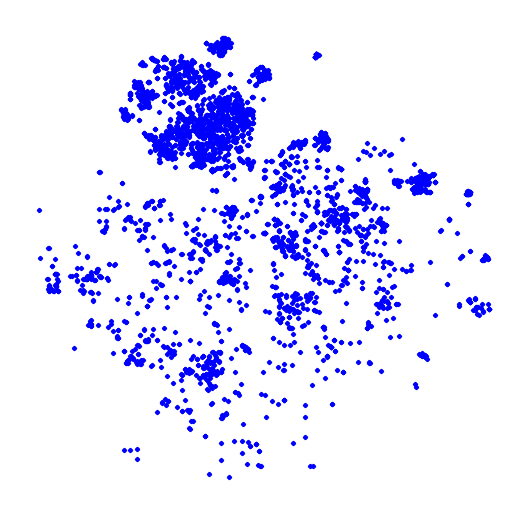

In [33]:
# get the (x, y) coordinates
x, y = XX.transpose()[0], XX.transpose()[1]
# draw the points into the landscape
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
# show the image
plt.axis('off')
plt.show()

### Document embedding via document descriptors

We can consider document descriptors to be some kind of summary of the document. We will use them to define a document embedding as the average of word embeddings of words that appear in document descriptors.

Let's first see how to access descriptors of the document with CELEX number 22015P0513(01).

In [74]:
descriptors = pg.execute("""
    SELECT * FROM document_descriptors WHERE document_celex_num='22015P0513(01)';
""")
descriptors = pg.fetchone()

In [75]:
print(descriptors)
#print(descriptors[0]['descriptor_name'])

('22015P0513(01)', 'Africa')


We gather them in a dictionary 'all_descriptors', where keys are CELEX numbers of documents and values are lists of their descriptors.

In [34]:
def get_descriptors(indices):
    """Returns a dictionary of descriptors for specified documents"""
    
    # The function returns dictionary 'descriptors' where keys are CELEX numbers of documents and values are descriptors
    # that correspond to appropriate document
    descriptors = {}
    
    for i in indices:
        celex = documents[i][1]
        doc_descriptors = pg.execute("""
            SELECT * FROM document_descriptors WHERE document_celex_num='{}';
            """.format(celex))
        doc_descriptors = pg.fetchall()
        for descriptor_instance in doc_descriptors:
            #print("I found sth")
            if celex not in descriptors:
                descriptors[celex] = [descriptor_instance[1]]
            else:
                descriptors[celex].append(descriptor_instance[1])
    return descriptors

In [35]:
print(documents[0])

(1, '12001C_DCL_09', 'Treaty of Nice amending the Treaty on European Union, the Treaties establishing the European Communities and certa in related acts', 'The fifteen Member States: Belgium, Denmark, Germany, Ireland, Greece, Spain, France, Italy, Luxembourg, Netherlands, Austria, Portugal, Finland, Sweden, United Kingdom', 'Declaration', datetime.date(2001, 2, 26), 'Avis juridique important|12001C/DCL/09Treaty of Nice amending the Treaty on European Union, the Treaties establishing the European Communities and certa in related acts - Declarations Adopted By The Conference - Declaration on Article 175 of the Treaty establishing the European CommunityOfficial Journal 080 , 10/03/2001 P. 0078 - 0078 9. Declaration on Article 175 of the Treaty establishing the European CommunityThe High Contracting Parties are determined to see the European Union play a leading role in promoting environmental protection in the Union and in international efforts pursuing the same objective at global level

In [36]:
all_descriptors = get_descriptors([i for i in range(N)])

We define new document embedding, run it on all documents and save it in variable 'descriptor_embedding'. Further, we reduce the dimension of the embedding and plot it.

In [37]:
def descriptor_embeddings(documents=documents, descriptors=all_descriptors, wv=wv_wiki_en):
    """Given a dictionary of documents with their descriptors, returns document embeddings based on the descriptors."""

    embedding = np.zeros((len(documents), wv.vector_size), dtype=np.float32)
    #go through documents
    for id, doc in enumerate(documents):
        # celex = doc['document_celex_num']
        celex = doc[1]
        doc_descriptors = descriptors[celex]
        doc_desctext = " ".join(doc_descriptors)
        embedding[id, :] = document_embedding_average(doc_desctext, " ", wv)
    return embedding
    

In [38]:
descriptors_embedding = descriptor_embeddings(documents)
# neighbors_descriptors_embedding = get_descriptor_embeddings()
# np.shape(descriptors_embedding)
descriptors_embedding_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(descriptors_embedding[:4000,:])

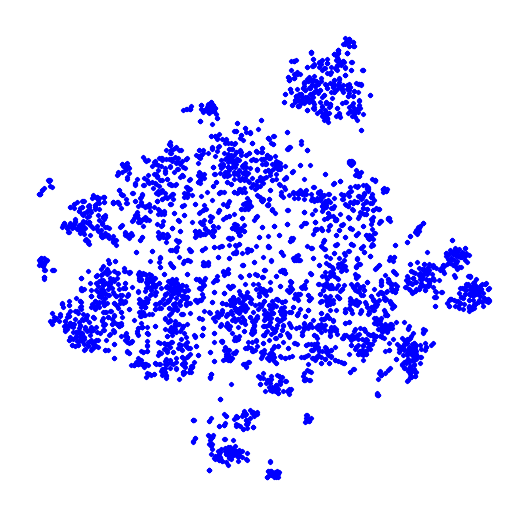

In [39]:
x, y = descriptors_embedding_transformed.transpose()[0], descriptors_embedding_transformed.transpose()[1]
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
plt.axis('off')
plt.show()

### Combined document embedding

We define a new document embedding as a linear combination of already defined ones. After reducing the dimension, we plot it.

In [54]:
def combined_embedding(document_embeddings, descriptor_embeddings, alpha):
    """Combines the two embeddings as a linear combination"""
    new_embedding = []
    for i in range(len(document_embeddings)):
        new_embedding.append(alpha*document_embeddings[i] + (1-alpha)*descriptor_embeddings[i])
    return new_embedding

In [55]:
combined = combined_embedding(non_null, descriptors_embedding, 0.5)
combined_transformed = TSNE(n_components=2, random_state=4).fit_transform(combined)

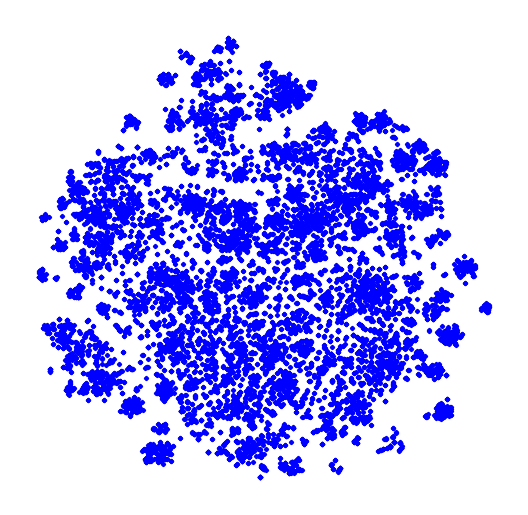

In [56]:
x, y = combined_transformed.transpose()[0], combined_transformed.transpose()[1]
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
plt.axis('off')
plt.show()

In [57]:
combined = combined_embedding(non_null, descriptors_embedding, 0.2)
combined_transformed = TSNE(n_components=2, random_state=4).fit_transform(combined)

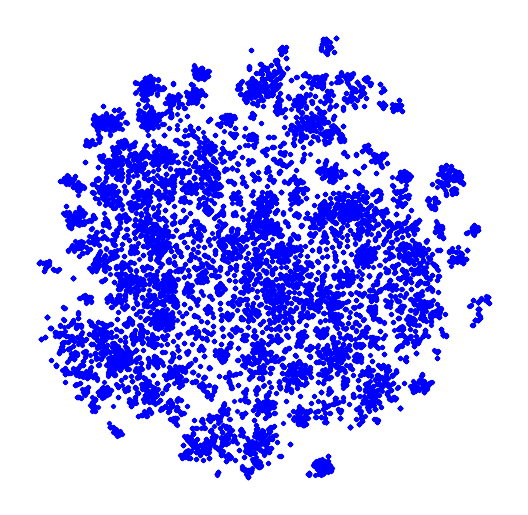

In [58]:
x, y = combined_transformed.transpose()[0], combined_transformed.transpose()[1]
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
plt.axis('off')
plt.show()

### Similarity of documents

In this section we will pick a specific document and find others that are most similar to it. We will use methotds we already used for word analysis and more.

We start by picking a document. We'll try to find similar ones.

In [77]:
doc_index = 168
doc_embedded = docembeddings_transformed[doc_index]
documents[doc_index]

(163,
 '21990A0515(03)',
 'Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol defining, for the period 18 January 1990 to 17 January 1993, the fishing opportunities and the financial contribution provided for by the Agreement between the European Economic Community and the Republic of Seychelles on fishing off Seychelles',
 'European Economic Community',
 'International agreement',
 datetime.date(1990, 4, 25),
 'Avis juridique important|21990A0515(03)Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol defining, for the period 18 January 1990 to 17 January 1993, the fishing opportunities and the financial contribution provided for by the Agreement between the European Economic Community and the Republic of Seychelles on fishing off SeychellesOfficial Journal L 125 , 15/05/1990 P. 0038 AGREEMENTin the form ofan Exchange of Letters concerning the provisional application of the Protocol d

In [78]:
def k_nearest_neighbors_doc(embedding, k, de=XX, similarity=euclid_similarity):
    """Get the k nearest neighbors of a particular document"""
    # calculate the similarities and revert it
    sims = [similarity(embedding, d) for d in de]
    # sort and get the corresponding values and weights
    distances = []
    neighbors = []
    indices = []
    for c, index in enumerate(np.argsort(sims)):
        # break if we had enough values
        if c == k:
            break
        distances.append(sims[index])
        neighbors.append(de[index])
        indices.append(index)
    # return the documents and weights
    return neighbors, distances, indices

We find $k$ documents whose document embeddings are closest to the chosen document. We save their document embeddings in 'doc_neighbors', their distances form chosen document's document embedding in 'doc_distances' and their indices in 'indices'.

In [79]:
k = 20
doc_neighbors, doc_distances, indices = k_nearest_neighbors_doc(doc_embedded, k, XX,
                                                       similarity=euclid_similarity)
print(doc_distances)

[0.0, 0.056430057, 0.11922323, 0.15985452, 0.22869234, 0.49838746, 0.5211276, 0.5552227, 0.76316833, 0.79548234, 0.85183984, 1.1302335, 1.1373074, 1.1441103, 1.1457726, 1.1646323, 1.1958969, 1.2089853, 1.3623277, 1.5354755]


In [80]:
print(indices)

[168, 229, 398, 988, 613, 388, 1377, 983, 1003, 1007, 799, 201, 284, 215, 696, 283, 334, 559, 209, 466]


Next, we plot our document and its neighbors. The lables in the plot correspond to the original indices of the documents (the indices documents had in the list 'documents').

In [81]:
def plot2D_doc_neighbors(neighbors, distances, di = doc_index, de = docembeddings_transformed):
    x, y = de.transpose()[0], de.transpose()[1]
    
    fig2, ax2 = plt.subplots(figsize=(3, 3), dpi=160, facecolor='w')
    
    n = de
    for i, txt in enumerate(n):
        for j, txt2 in enumerate(neighbors):
            if np.array_equal(txt, txt2):
                weight = 'normal'
                color = 'black'
                size = 8
                if i == di:
                    weight = 'bold'
                    color = 'green'
                    size = 10
                ax2.scatter(x[i], y[i], 5)
                ax2.annotate(str(non_null_id[i]), (x[i], y[i]), color=color, weight=weight, ha='right', va='top', size=size)
                # indices[j] = non_null_id[i]
    plt.axis('off')
    plt.show()
    return None

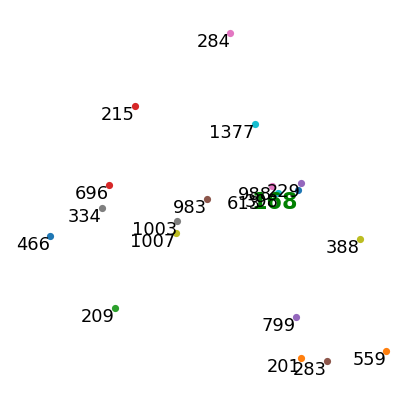

In [82]:
plot2D_doc_neighbors(doc_neighbors, doc_distances)

In [83]:
for i in indices:
    d = documents[i]
    print(d[2]) # document title
    print(' ')

Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol defining, for the period 18 January 1990 to 17 January 1993, the fishing opportunities and the financial contribution provided for by the Agreement between the European Economic Community and the Republic of Seychelles on fishing off Seychelles
 
Agreement in the form of an exchange of letters concerning the provisional application of the Protocol defining, for the period 18 January 1993 to 17 January 1996, the fishing opportunities and the financial contribution provided for by the Agreement between the European Community and the Republic of Seychelles on fishing off Seychelles
 
Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol defining, for the period from 18 January to 17 January 1999, the fishing oppportunities and financial contribution provided for by the Agreement between the European Economic Community and the Republic of S

In [84]:
#celex_num = documents[indices[0]]['document_celex_num']
#print("CELEX number of chosen document: {}".format(celex_num))
#neighbors_celex_nums = [documents[i]['document_celex_num'] for i in indices]
#neighbours_documents = []

In [85]:
#neighbors_descriptors = get_descriptors(indices)
#print(neighbors_descriptors)

In [86]:
#neighbors_descriptors_embedding = descriptor_embeddings()

Let's embedd the database with descriptor embedding. On the plot shown below we see the embeddings are close, but not as close as they were when embedded with simple document embedding.

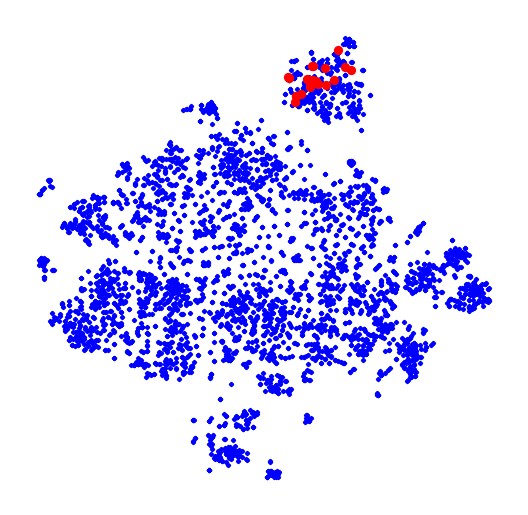

In [94]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')

DET = descriptors_embedding_transformed
x, y = DET.transpose()[0], DET.transpose()[1]
ax.scatter(x, y, 2, marker='x', c='b')

DET = descriptors_embedding_transformed[indices,:]
x, y = DET.transpose()[0], DET.transpose()[1]
ax.scatter(x, y, 10, marker='o', c='r')

plt.axis('off')
plt.show()

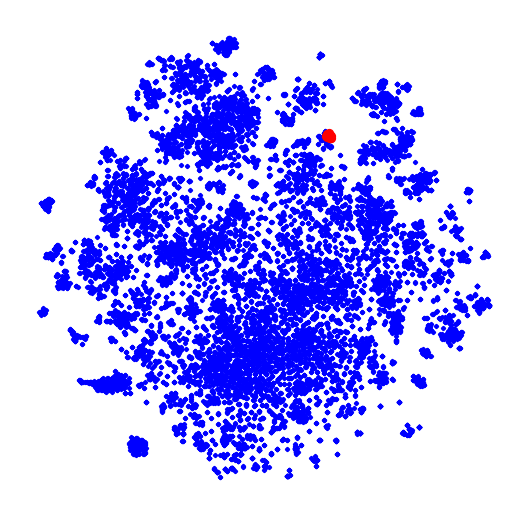

In [95]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')


DET = docembeddings_transformed
x, y = DET.transpose()[0], DET.transpose()[1]
ax.scatter(x, y, 2, marker='x', c='b')

DET = docembeddings_transformed[indices,:]
x, y = DET.transpose()[0], DET.transpose()[1]
ax.scatter(x, y, 10, marker='o', c='r')

plt.axis('off')
plt.show()

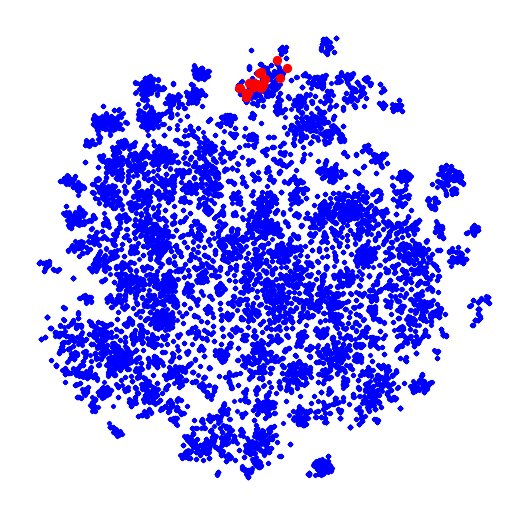

In [93]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')


DET = combined_transformed
x, y = DET.transpose()[0], DET.transpose()[1]
ax.scatter(x, y, 2, marker='x', c='b')

DET = combined_transformed[indices,:]
x, y = DET.transpose()[0], DET.transpose()[1]
ax.scatter(x, y, 10, marker='o', c='r')

plt.axis('off')
plt.show()

In [107]:
focus_desc_embedding = descriptors_embedding_transformed[indices[0]]
des_neighbors, des_distances, indices2 = k_nearest_neighbors_doc(focus_desc_embedding, k, de=descriptors_embedding_transformed)

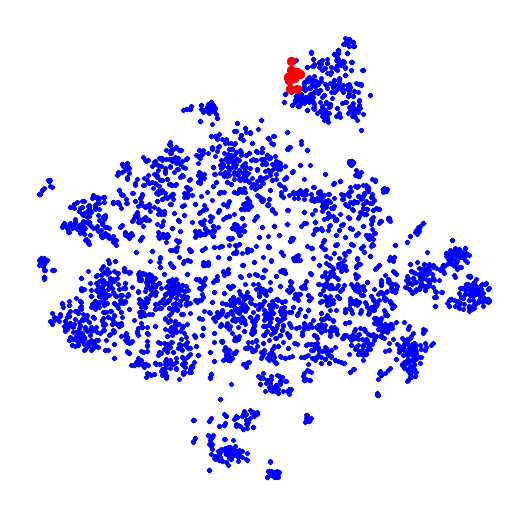

In [108]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')

DET = descriptors_embedding_transformed
x, y = DET.transpose()[0], DET.transpose()[1]
ax.scatter(x, y, 2, marker='x', c='b')

DET = descriptors_embedding_transformed[indices2,:]
x, y = DET.transpose()[0], DET.transpose()[1]
ax.scatter(x, y, 10, marker='o', c='r')

plt.axis('off')
plt.show()

In [54]:
for i in indices2:
    print('Title of neighboring document with id {}: {}'.format(i, documents[i]['document_title']))
    print(' ')

Title of neighboring document with id 168: Agreement between the European Economic Community and the Republic of Sierra Leone on fishing off Sierra Leone - Protocol on the fishing rights and financial contribution provided for in the Agreement between the European Economic Community and the Republic of Sierra Leone on fishing off Sierra Leone
 
Title of neighboring document with id 198: PROTOCOL establishing for the period 16 June 1991 to 15 June 1993 the fishing rights and financial compensation provided for in the Agreement between the European Economic Community and the Government of the Republic of Guinea-Bissau on fishing off the coast of Guinea-Bissau 
 
Title of neighboring document with id 3538: 91/570/EEC: Council Decision of 7 October 1991 on the conclusion of the Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol establishing for the period 16 June 1991 to 15 June 1993 the fishing rights and financial compensation provided 

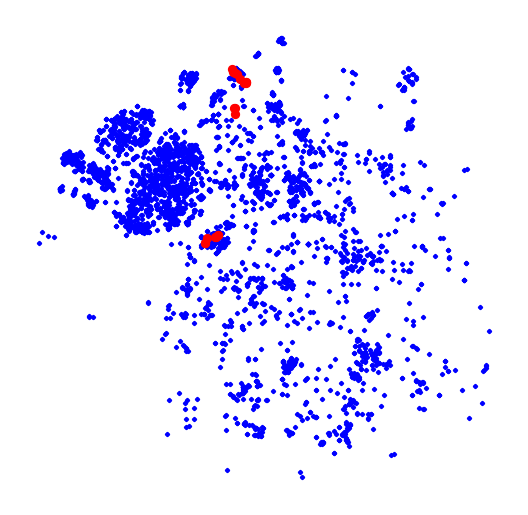

In [55]:
# get the (x, y) coordinates
x, y = XX.transpose()[0], XX.transpose()[1]
# draw the points into the landscape
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
# get the (x, y) coordinates of neighbors
tempXX = XX[indices2,:]
x, y = tempXX.transpose()[0], tempXX.transpose()[1]
# draw the points into the landscape
ax.scatter(x,  y,  10, marker='o', c='r')
# show the image
plt.axis('off')
plt.show()

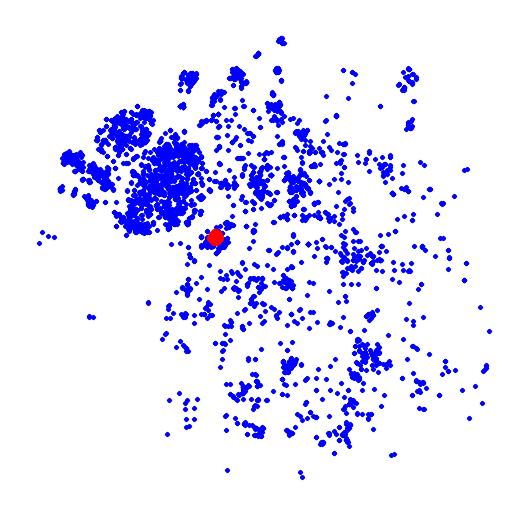

In [56]:
# get the (x, y) coordinates
x, y = XX.transpose()[0], XX.transpose()[1]
# draw the points into the landscape
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
# get the (x, y) coordinates of neighbors
tempXX = XX[indices,:]
x, y = tempXX.transpose()[0], tempXX.transpose()[1]
# draw the points into the landscape
ax.scatter(x,  y,  10, marker='o', c='r')
# show the image
plt.axis('off')
plt.show()

We will plot combined embedding for values of $\alpha = 0,\ 0.25,\ 0.5,\ 0.75,\ 1$. We color $k$ nearest neighbors based on the simple document embedding with red and $k$ nearest neighbors based on the descriptor embedding with yellow.

In [61]:
def plotAlphaBeta(emb1, emb2, alpha, indices1=indices, indices2=indices2):
    emb = combined_embedding(emb1, emb2, alpha)
    temp1 = emb[indices, :]
    temp2 = emb[indices2, :]
    
    fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
    x, y = emb.transpose()[0], emb.transpose()[1]
    ax.scatter(x,  y,  2, marker='x', c='b') 
    
    x1, y1 = temp1.transpose()[0], temp1.transpose()[1]
    ax.scatter(x1,  y1,  5, marker='o', c='r')
    
    x2, y2 = temp2.transpose()[0], temp2.transpose()[1]
    ax.scatter(x2,  y2,  5, marker='o', c='y')
    
    plt.axis('off')
    plt.show()
    return None

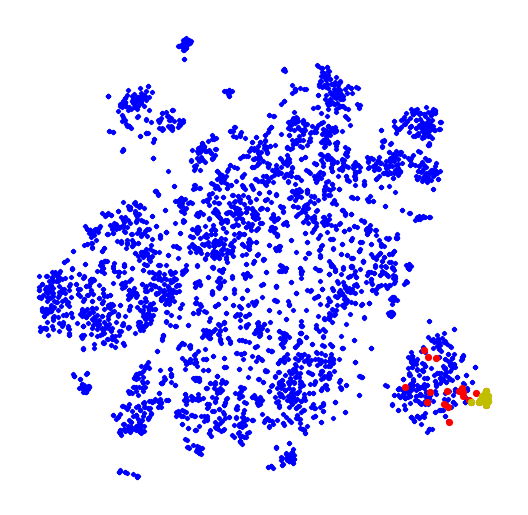

In [62]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 0)

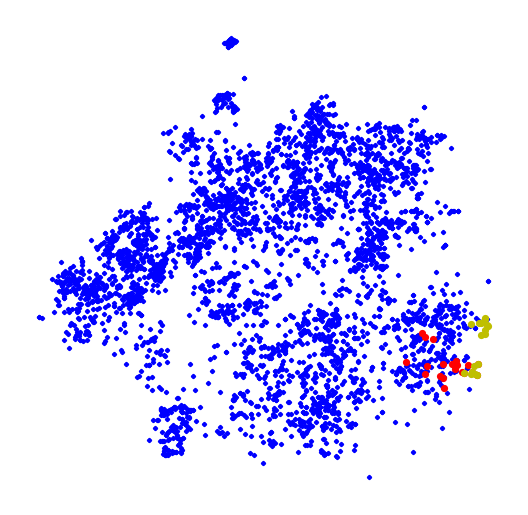

In [63]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 0.25)

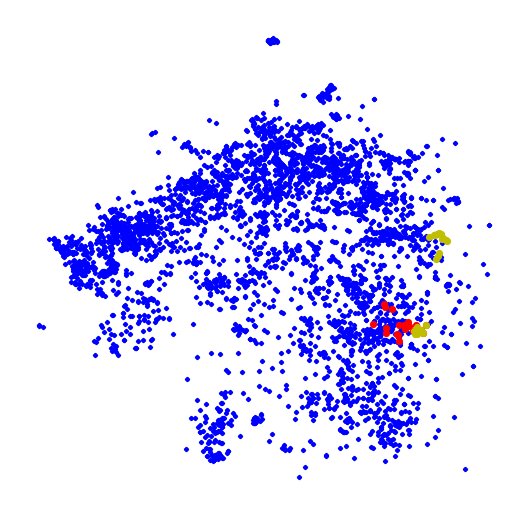

In [64]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 0.5)

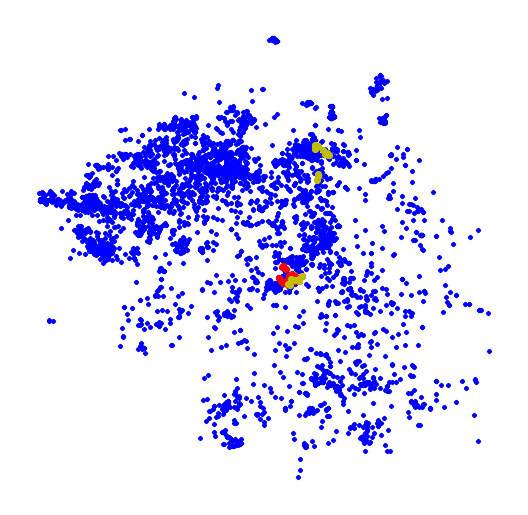

In [65]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 0.75)

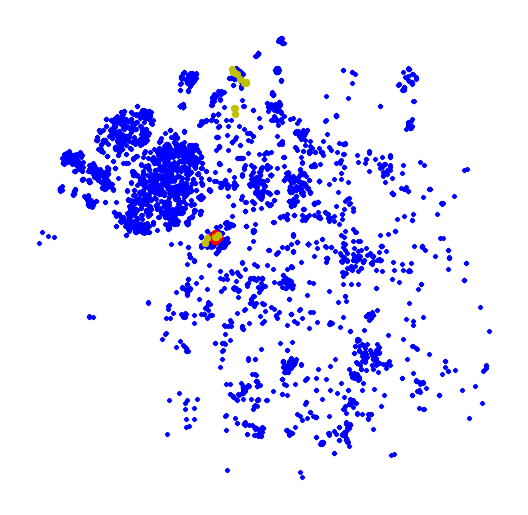

In [66]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 1)

Upper plot shows combined embedding when $\alpha = 1$, which is the same as simple document embedding. We notice that some of the documents that are close when embedded with descriptor embedding (yellow dots), are quite far when embedded with simple document embedding.

Let's find the most distant one.

In [67]:
dists = [euclid_similarity(XX[indices[0], :], XX[i, :]) for i in indices]
ind_max = indices[dists.index(max(dists))]
documents[ind_max]

{'document_id': 308,
 'document_celex_num': '21995A0731(01)',
 'document_title': 'Protocol establishing for the period from 1 July 1994 to 30 June 1997 the fishing rights and financial compensation provided for in the Agreement between the European Economic Community and the Government of the Republic of Equatorial Guinea on fishing off the coast of Equatorial Guinea',
 'document_author': 'Equatorial Guinea',
 'document_form': 'Protocol',
 'document_date': datetime.date(1997, 3, 24),
 'document_text': 'Avis juridique important|21995A0731(01)Protocol establishing for the period from 1 July 1994 to 30 June 1997 the fishing rights and financial compensation provided for in the Agreement between the European Economic Community and the Government of the Republic of Equatorial Guinea on fishing off the coast of Equatorial GuineaOfficial Journal L 180 , 31/07/1995 P. 0002 - 0007 PROTOCOL establishing for the period from 1 July 1994 to 30 June 1997 the fishing rights and financial compensation

It doesn't seem like it's quite that different. This in combination with plots of combined embeddings for different $\alpha$ suggests that simple document embedding doesn't represent "closeness" of data quite as well as descriptor embedding. 

Let's test our hypothesis on more exaples.

In [76]:
doc_index = 1998
doc_embedded = docembeddings_transformed[doc_index]

k = 10
doc_neighbors, doc_distances, indices = k_nearest_neighbors_doc(doc_embedded, k, XX,
                                                       similarity=euclid_similarity)
for i in indices:
    d = documents[i]
    print(d[2]) # document title
    print(' ')

Council Directive 79/831/EEC of 18 September 1979 amending for the sixth time Directive 67/548/EEC on the approximation of the laws, regulations and administrative provisions relating to the classification, packaging and labelling of dangerous substances
 
European Agreement on the Exchange of Reagents for Determining Blood Groups - Protocol to the Agreement
 
Council Directive 78/631/EEC of 26 June 1978 on the approximation of the laws of the Member States relating to the classification, packaging and labelling of dangerous preparations (pesticides)
 
Council Directive 67/548/EEC of 27 June 1967 on the approximation of laws, regulations and administrative provisions relating to the classification, packaging and labelling of dangerous substances
 
Council Directive 73/173/EEC of 4 June 1973 on the approximation of Member States laws, regulations and administrative provisions relating to the classification, packaging and labelling of dangerous preparations (solvents)
 
Council Directive